In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%load_ext autoreload
%autoreload 2

from preparePlots import *

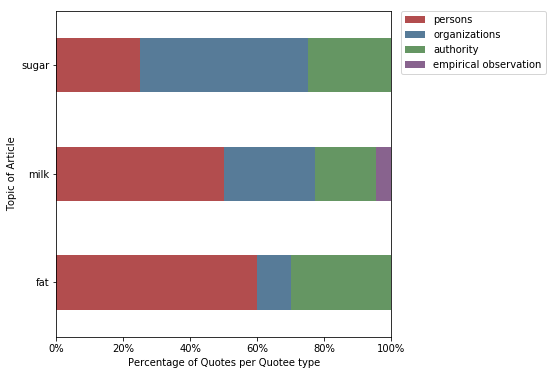

In [2]:
def plotNumOfQuotes():
    
    #read df
    df = plotNumOfQuotesDF()

    #horizontal barplot
    ax = df.plot.barh(stacked=True, figsize=(6, 6), colormap=ListedColormap(sns.color_palette("Set1", n_colors=df.shape[1], desat=.5)))

    #Labels
    ax.set(ylabel="Topic of Article", xlabel="Percentage of Quotes per Quotee type")
    ax.legend(ncol=1, frameon=True)
    plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
    locs, labels = plt.xticks()
    labels = [str(int(l*100))+'%' for l in locs]
    plt.xticks(locs, labels)
    plt.xlim(xmin = 0, xmax = 1)

    #Depiction
    plt.savefig('plots/CountQuotes.png', dpi=1200, bbox_inches = 'tight')
    plt.show()
plotNumOfQuotes()

In [ ]:
def plotHeatMap():
    
    #Data manipulation
    data = topics[['articleTopic', 'quoteTopic']].groupby(['articleTopic', 'quoteTopic']).size().reset_index(name='counts').pivot(index='articleTopic', columns='quoteTopic', values='counts').fillna(0)
    #normalization
    data = data.div(data.sum(axis=1), axis=0)
    
    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(8, 8))
    sns.set_color_codes("pastel")

    #Plot
    ax = sns.heatmap(data)

    #Labels
    ax.set(ylabel="Topic of Article", xlabel="Topic of Quote")
    
    #Depiction
    plt.savefig('plots/TopicsHeatMap.png', dpi=1200, bbox_inches = 'tight')
    plt.show()    
plotHeatMap()

In [ ]:
documents = documents.select('quotes').toPandas()

In [ ]:
documents = documents['quotes'].apply(pd.Series).stack().reset_index(level=1, drop=True).apply(pd.Series)

In [ ]:
def plotTopQuotees():
    
    #Data manipulation    
    data = documents[documents['quoteeType'] == 'PERSON']['quotee'].value_counts().reset_index()
    data.columns = ['quotee', 'count']
    data = data.head(20)
    data = data.drop(3) # dropping â

    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))

    #Barplots
    sns.set_color_codes("pastel")
    sns.barplot(x="count", y="quotee", data=data, ax=ax, label="total", color='b')

    #Labels
    ax.set(ylabel="Quotee Name", xlabel="Number of Quotes")
    sns.despine()
    locs, labels = plt.xticks()
    labels = [human_format(l) for l in locs]
    plt.xticks(locs, labels)

    #Depiction
    plt.savefig('plots/TopQuotees.png', dpi=1200, bbox_inches = 'tight')
    plt.show()
plotTopQuotees()

In [ ]:
def plotTopOrganizations():
    
    #Data manipulation    
    data = documents[documents['quoteeType'] == 'ORG']['quoteeAffiliation'].value_counts().reset_index()
    data.columns = ['organization', 'count']
    data = data.head(20)
    #data = data.drop(3) # dropping â

    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))

    #Barplots
    sns.set_color_codes("pastel")
    sns.barplot(x="count", y="organization", data=data, ax=ax, label="total", color='b')

    #Labels
    ax.set(ylabel="Organization Name", xlabel="Number of Quotes")
    sns.despine()
    locs, labels = plt.xticks()
    labels = [human_format(l) for l in locs]
    plt.xticks(locs, labels)

    #Depiction
    plt.savefig('plots/TopOrganizations.png', dpi=1200, bbox_inches = 'tight')
    plt.show()
plotTopOrganizations()